In [1]:
from scipy.optimize import fsolve
import math 
import numpy as np
import matplotlib.pyplot as plt

''' Current Bug: Equation Solver blows up when you use the value So = 4760 W/m^2
 - Read Jun Yang for sensitivity test of k1,k2,k3'''

def universal_func(So=2000, Fo=0, mm_dry = 0.028, assumption = 'WTG', p_guess=(250,250,200,200,200,20)):
    g = 13.7 #m/s^2 #gravity
    Pc = 6e4
    Po = 1.01e5
    R_star = 8.3145
    def equations(p): 
        T1, T2, Fc = p 

        ### Constants
        es0 = 611.2
        M = 0.018
        To = 273.15
        mass_ratio = M/mm_dry

        sigma = 5.67e-8 #W /m^2 K^4  Stefan Boltzmann Constant
        
        H = ((R_star/mm_dry)*T2)/g #scale height
        
        Tc = 230 #Cloud emission temp
        Z_a = np.log(Po/Pc)*H #convection height
        Cp = 1005.7 #J/kgK #heat capacity
        L = 2.501e6 # J/kg #latent heat of vaporization

        es_1 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T1))
        w_1 = mass_ratio*es_1/(Po - es_1) #saturated mixing ratio
        q1_s = w_1/(1+w_1)

        es_2 = es0*pow(np.e, L/(R_star/M)*(1/To - 1/T2))
        w_2 = mass_ratio*es_2/(Pc - es_2) #saturated mixing ratio
        q2_s = w_2/(1+w_2)

        RH_1 = 0.9 #Relative Humidity
        RH_2 = 0.8 
        #RH_3 = 0.3
        q1 = RH_1 * q1_s
        q2 = RH_2 * q2_s #specific humidity
        #q3 = RH_3 * q2_s #specific humidity

        #So = 2000 # W/m^2 Solar insolation
        #Fo' = 0 # Ocean heat transport

        #fc = 1.0 # cloud fraction
        
        k1 = 0.2 # Fraction of heat transport to the nightside deposited in the boundary layer
        k2 = 1000 # Relates water vapor to the infrared opacity 
        k3 = 0.08 # relates the strength of convection to the cloud fraction
        #Fd = k1*Fa

        fc = 0
        alpha_p = 0.09+fc - 0.09*fc # planetary albedo
        
        def Tv(T,mass_ratio,w):
            Tv = T*((1 + (w/mass_ratio))/(1+w)) # w is the water vapor mixing ratio
            return Tv

        epsilon_2 = 1 - np.exp(-k2*q2) #emissivity
        #epsilon_3 = 1 - np.exp(-k2*q3)

        Eq2 = (1/2)*So*(1-alpha_p)-Fc - Fo + (1-fc)*epsilon_2*sigma*T2**4 + fc*sigma*Tc**4 - sigma*T1**4

        Eq3 = Fc - Fa + (1-fc)*epsilon_2*sigma*T1**4 + fc*sigma*T1**4 - 2*(1-fc)*epsilon_2*sigma*T2**4 - 2*fc*sigma*Tc**4

        #Eq4 = Fa - Fd + epsilon_3*sigma*T4**4 - 2*epsilon_3*sigma*T3**4

        #Eq5 = Fo + Fd + epsilon_3*sigma*T3**4 - sigma*T4**4
        
        #Eq6_WTG = T2 - T3

        #Eq6_WBG = Tv(T2,mass_ratio,(q2/(1-q2))) - Tv(T3,mass_ratio,(q3/(1-q3)))

        Eq7 = Cp*T1 + L*q1 - (Cp*T2+L*q2_s + g*Z_a)
        
        if assumption == 'WTG': 
            Eq6 = Eq6_WTG
        elif assumption == 'WBG':
            Eq6  = Eq6_WBG
        if index==0:
            return (Eq2, Eq3, Eq7)
        if index==1:
            return(q1,q2,alpha_p,epsilon_2)
        """
        # Old version, to be deleted
        def Eq2(So,alpha_p,Fc,Fo,epsilon_2,sigma,fc,Tc):     
            return (1/2)*So*(1-alpha_p)-Fc - Fo + (1-fc)*epsilon_2*sigma*T2**4 + fc*sigma*Tc**4 - sigma*T1**4

        def Eq3(Fc,Fa,epsilon_2,sigma,T1,T2,Tc):
            return Fc - Fa + (1-fc)*epsilon_2*sigma*T1**4 + fc*sigma*T1**4 - 2*(1-fc)*epsilon_2*sigma*T2**4 - 2*fc*sigma*Tc**4

        def Eq4(Fa,Fd,T3,sigma,T4): 
            return Fa - Fd + epsilon_3*sigma*T4**4 - 2*epsilon_3*sigma*T3**4

        def Eq5(Fo,Fd,epsilon_3,sigma, T3, T4):  
            return Fo + Fd + epsilon_3*sigma*T3**4 - sigma*T4**4

        def Eq6(T2,T3): 
            return T2 - T3

        def Eq7(T1, T2):
            return Cp*T1 + L*q1_s - (Cp*T2+L*q2_s + g*Z_a)

        return (Eq2(So,alpha_p,Fc,Fo,epsilon_2,sigma,fc,Tc), Eq3(Fc,Fa,epsilon_2,sigma,T1,T2,Tc), 
                Eq4(Fa,Fd,T3,sigma,T4), Eq5(Fo,Fd,epsilon_3,sigma, T3, T4),
                Eq6(T2,T3), Eq7(T1,T2))
        """
    index=0
    T1, T2, Fc = fsolve(equations,p_guess)       
    fc_2 = 0
    if fc_2 >=1:
        print('cloud fraction: ',fc_2)
    index=1
    q1,q2,alpha_p,epsilon_2 = equations((T1, T2, Fc))   
    return (T1, T2, Fc, fc_2,
            q1,q2,alpha_p,epsilon_2)

In [2]:
universal_func(So=1500,p_guess=(250,250,250,250,200,200), assumption='WBG')

ValueError: too many values to unpack (expected 3)

In [4]:
so = np.linspace(1000,4500,100)
nele = len(so)
T1_arr_WBG, T2_arr_WBG, T3_arr_WBG, T4_arr_WBG, Fa_arr_WBG, Fc_arr_WBG, fc_arr_WBG = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)
q1_arr_WBG,q2_arr_WBG,q3_arr_WBG,alpha_p_arr_WBG,epsilon_2_arr_WBG,epsilon_3_arr_WBG = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)

initial_guess = (250,250,200,200,200,20)
for idx,s in enumerate(so):
    T1_arr_WBG[idx], T2_arr_WBG[idx], T3_arr_WBG[idx], T4_arr_WBG[idx], Fa_arr_WBG[idx], Fc_arr_WBG[idx], fc_arr_WBG[idx], \
    q1_arr_WBG[idx],q2_arr_WBG[idx],q3_arr_WBG[idx],alpha_p_arr_WBG[idx],epsilon_2_arr_WBG[idx],epsilon_3_arr_WBG[idx] = universal_func(So = s, assumption  = 'WBG', p_guess = initial_guess)
    initial_guess = (T1_arr_WBG[idx], T2_arr_WBG[idx], T3_arr_WBG[idx], T4_arr_WBG[idx], Fa_arr_WBG[idx], Fc_arr_WBG[idx])
    
    
#print(np.where(1 <= epsilon_3_arr_WTG))
#print(epsilon_3_arr_WTG[50:52])

ValueError: too many values to unpack (expected 3)

In [4]:
so = np.linspace(1000,4500,100)
nele = len(so)
T1_arr_WTG, T2_arr_WTG, T3_arr_WTG, T4_arr_WTG, Fa_arr_WTG, Fc_arr_WTG, fc_arr_WTG = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)
q1_arr_WTG,q2_arr_WTG,q3_arr_WTG,alpha_p_arr_WTG,epsilon_2_arr_WTG,epsilon_3_arr_WTG = np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele), np.zeros(nele)

initial_guess = (250,250,200,200,200,20)
for idx,s in enumerate(so):
    T1_arr_WTG[idx], T2_arr_WTG[idx], T3_arr_WTG[idx], T4_arr_WTG[idx], Fa_arr_WTG[idx], Fc_arr_WTG[idx], fc_arr_WTG[idx], \
    q1_arr_WTG[idx],q2_arr_WTG[idx],q3_arr_WTG[idx],alpha_p_arr_WTG[idx],epsilon_2_arr_WTG[idx],epsilon_3_arr_WTG[idx] = universal_func(So = s, assumption  = 'WTG', p_guess = initial_guess)
    initial_guess = (T1_arr_WTG[idx], T2_arr_WTG[idx], T3_arr_WTG[idx], T4_arr_WTG[idx], Fa_arr_WTG[idx], Fc_arr_WTG[idx])

In [3]:
def plot_diff(so, xlab = 'Steller Flux', xunit = 'W/$m^2$'): 
    fig = plt.figure(figsize = (12,10))
    plt.suptitle('WBG - WTG', fontsize = 16)
    #arr_list_WBG = [q1_arr_WBG,q2_arr_WBG,q3_arr_WBG,fc_arr_WBG]
    #arr_list_WTG = [q1_arr_WTG,q2_arr_WTG,q3_arr_WTG,fc_arr_WTG]
    arr_list_WBG = [T1_arr_WBG,T2_arr_WBG,T3_arr_WBG,T4_arr_WBG]
    arr_list_WTG = [T1_arr_WTG,T2_arr_WTG,T3_arr_WTG,T4_arr_WTG]
    #arr_list_WBG = [Fa_arr_WBG, Fc_arr_WBG, alpha_p_arr_WBG,epsilon_2_arr_WBG,epsilon_3_arr_WBG]
    #arr_list_WTG = [Fa_arr_WTG, Fc_arr_WTG, alpha_p_arr_WTG,epsilon_2_arr_WTG,epsilon_3_arr_WTG]
    arr_list = [arr_list_WBG[idx] - arr_list_WTG[idx] for idx in range(4) ]

    nele = len(arr_list)
    #name_list = ['q1','q2','q3','fc']
    #unit_list = [r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$']
    name_list = ['T1','T2','T3','T4']
    unit_list = ['K','K','K','K']
    
    if nele % 2 == 0:
        nrows = (nele)//2
    else:
        nrows = (nele)//2+1, 
    ncols = 2
    print(np.shape(arr_list))

    for idx, arr in enumerate(arr_list):
        ax  =plt.subplot(nrows, ncols, idx + 1)

        ax.plot(so, arr, color = 'k', markersize = 9, label = 'WBG-WTG')
        #ax.set_title(assumption)
        ax.set_xlabel(xlab +'('+ xunit +')')
        ax.set_ylabel(name_list[idx]+'('+unit_list[idx]+')')
        #plt.xlim(1000,2400)
        #plt.ylim(160,320)
        if idx ==3: 
            plt.legend(frameon = False)
    plt.savefig("WTG_WBG_diff_T1-T4.png")
    plt.close()

    return fig
plot_diff(so)

NameError: name 'so' is not defined

(5, 100)
(5, 100)


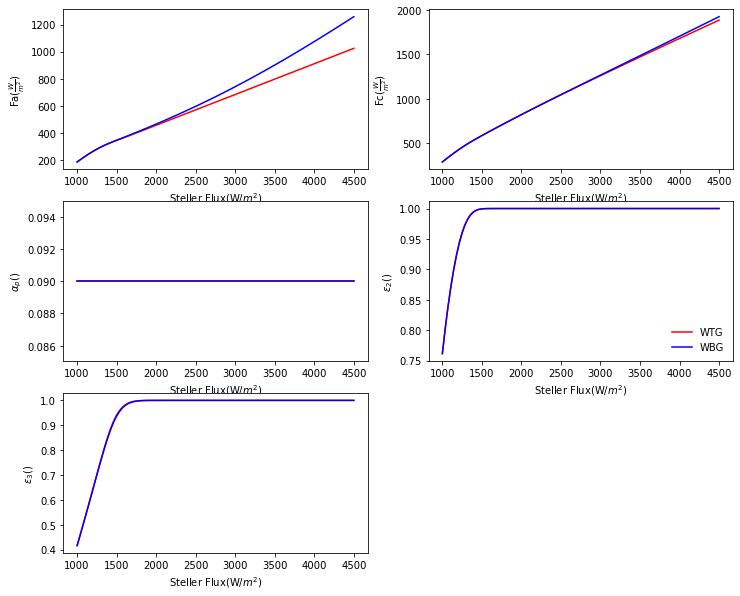

In [6]:
def plot_across_so(so, xlab = 'Steller Flux', xunit = 'W/$m^2$'): 
    fig = plt.figure(figsize = (12,10))
    for i_assump, (assumption, my_color) in enumerate(zip(['WTG','WBG'], ['r','b'])):
        if assumption == 'WBG':
            #arr_list = [q1_arr_WBG,q2_arr_WBG,q3_arr_WBG,fc_arr_WBG]
            #arr_list = [T1_arr_WBG,T2_arr_WBG,T3_arr_WBG,T4_arr_WBG]
            arr_list = [Fa_arr_WBG, Fc_arr_WBG, alpha_p_arr_WBG,epsilon_2_arr_WBG,epsilon_3_arr_WBG]
        elif assumption == 'WTG':
            #arr_list = [q1_arr_WTG,q2_arr_WTG,q3_arr_WTG,fc_arr_WTG]
            #arr_list = [T1_arr_WTG,T2_arr_WTG,T3_arr_WTG,T4_arr_WTG]
            arr_list = [Fa_arr_WTG, Fc_arr_WTG, alpha_p_arr_WTG,epsilon_2_arr_WTG,epsilon_3_arr_WTG]

        
        nele = len(arr_list)
        #name_list = ['T1','T2','T3','T4']
        #unit_list = ['K','K','K','K']
        #name_list = ['q1','q2','q3','fc']
        #unit_list = [r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$']
        name_list = ['Fa','Fc',r'$\alpha_p$',r'$\epsilon_2$',r'$\epsilon_3$']
        unit_list = [r'$\frac{W}{m^2}$',r'$\frac{W}{m^2}$','','', '']
        
        if nele % 2 == 0:
            nrows = (nele)//2
        else:
            nrows = (nele)//2+1
        ncols = 2
        print(np.shape(arr_list))

        for idx, arr in enumerate(arr_list):
            ax  =plt.subplot(nrows, ncols, idx + 1)

            ax.plot(so, arr, color = my_color, markersize = 9, label = assumption)

            #ax.set_title(assumption)
            ax.set_xlabel(xlab +'('+ xunit +')')
            ax.set_ylabel(name_list[idx]+'('+unit_list[idx]+')')
            #plt.xlim(1000,2400)
            #plt.ylim(160,320)
            if idx ==3: 
                plt.legend(frameon = False)
    plt.savefig("WTG_WBG_compare_T1-T4.png")
    plt.close()

    return fig

plot_across_so(so)

### plotting

(4, 100)
(4, 100)


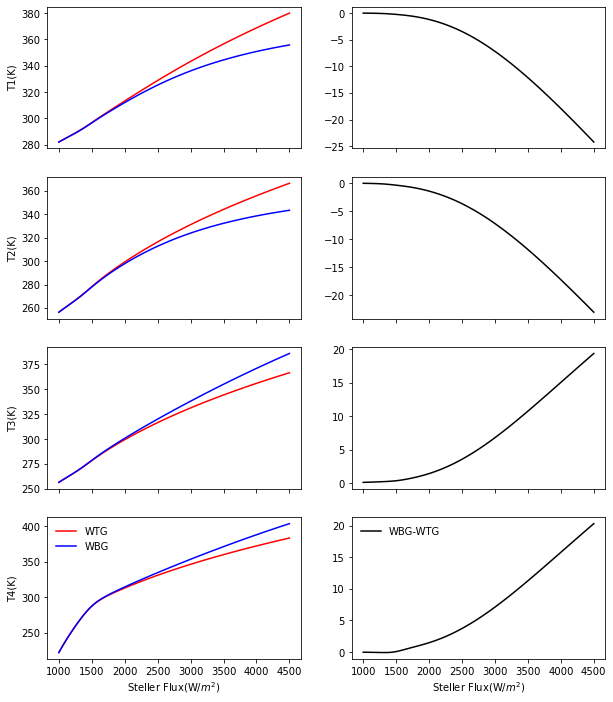

In [9]:
def plot_8panels(so, xlab = 'Steller Flux', xunit = 'W/$m^2$'): 
   
    
    
    #arr_list_WBG = [q1_arr_WBG,q2_arr_WBG,q3_arr_WBG,fc_arr_WBG]
    #arr_list_WTG = [q1_arr_WTG,q2_arr_WTG,q3_arr_WTG,fc_arr_WTG]
    arr_list_WBG = [T1_arr_WBG,T2_arr_WBG,T3_arr_WBG,T4_arr_WBG]
    arr_list_WTG = [T1_arr_WTG,T2_arr_WTG,T3_arr_WTG,T4_arr_WTG]
    #arr_list_WBG = [Fa_arr_WBG, Fc_arr_WBG, alpha_p_arr_WBG,epsilon_2_arr_WBG,epsilon_3_arr_WBG]
    #arr_list_WTG = [Fa_arr_WTG, Fc_arr_WTG, alpha_p_arr_WTG,epsilon_2_arr_WTG,epsilon_3_arr_WTG]
    
    
    name_list = ['T1','T2','T3','T4']
    unit_list = ['K','K','K','K']
    #name_list = ['q1','q2','q3','fc']
    #unit_list = [r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$',r'$\frac{kg}{kg}$']
    #name_list = ['Fa','Fc',r'$\alpha_p$',r'$\epsilon_2$',r'$\epsilon_3$']
    #unit_list = [r'$\frac{W}{m^2}$',r'$\frac{W}{m^2}$','','', '']
    nele = len(name_list)
    ncols = 2
    nrows = nele
    fig, axs = plt.subplots(nrows, ncols, sharex = True, figsize = (10,12))
    ax = axs[0][0]
    #nele = len(arr_list)
    #name_list = ['T1','T2','T3','T4']
    #unit_list = ['K','K','K','K']

    
    for i_assump, (assumption, my_color) in enumerate(zip(['WTG','WBG'], ['r','b'])):
        if assumption == 'WBG':
            arr_list = arr_list_WBG
        elif assumption == 'WTG':
            arr_list = arr_list_WTG


        
        print(np.shape(arr_list))

        for idx, arr in enumerate(arr_list):
            ax = axs[idx][0]

            ax.plot(so, arr, color = my_color, markersize = 9, label = assumption)

            #ax.set_title(assumption)
            #ax.set_xlabel(xlab +'('+ xunit +')')
            ax.set_ylabel(name_list[idx]+'('+unit_list[idx]+')')
            #plt.xlim(1000,2400)
            #plt.ylim(160,320)
            if idx == nele - 1: 
                ax.legend(frameon = False)
                ax.set_xlabel(xlab +'('+ xunit +')')
    
    
    ### plot difference
    #plt.suptitle('WBG - WTG', fontsize = 16)

    
    arr_list = [arr_list_WBG[idx] - arr_list_WTG[idx] for idx in range(nele) ]

    for idx, arr in enumerate(arr_list):
        ax = axs[idx][1]
        ax.plot(so, arr, color = 'k', markersize = 9, label = 'WBG-WTG')
        #ax.set_title(assumption)
        
        #ax.set_ylabel(name_list[idx]+'('+unit_list[idx]+')')
        #plt.xlim(1000,2400)
        #plt.ylim(160,320)
        if idx == nele -1: 
            plt.legend(frameon = False)
            plt.xlabel(xlab +'('+ xunit +')')
    plt.savefig("WTG_WBG_q1-q3.png")
    plt.close()
    
    #fig, axs = plt.subplots(nrows, ncols, sharex = True, figsize = (10,12))
      
        
    

    return fig
plot_8panels(so)

31
31
33
33


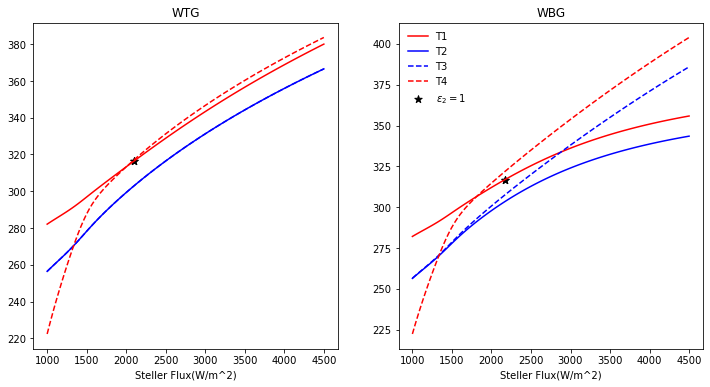

In [8]:
fig = plt.figure(figsize =(12,6))
plt.rcParams['savefig.facecolor']='white'

for i_assumption, assumption in enumerate(['WTG','WBG']): 
    ax = plt.subplot(1,2,1+i_assumption)
    ax.set_title(assumption)
    
    arr_list_WBG = [T1_arr_WBG,T2_arr_WBG,T3_arr_WBG,T4_arr_WBG]
    arr_list_WTG = [T1_arr_WTG,T2_arr_WTG,T3_arr_WTG,T4_arr_WTG]
    
    if assumption == 'WBG':
        arr_list = arr_list_WBG
        epsilon_arr = epsilon_2_arr_WBG
    elif assumption == 'WTG': 
        arr_list = arr_list_WTG
        epsilon_arr = epsilon_2_arr_WTG
    
    ax.plot(so, arr_list[0], color = 'r', linestyle = '-', label = 'T1')
    ax.plot(so, arr_list[1], color = 'b', linestyle = '-', label = 'T2')
    ax.plot(so, arr_list[2], color = 'b', linestyle = '--', label = 'T3')
    ax.plot(so, arr_list[3], color = 'r', linestyle = '--', label = 'T4')
    
    
    transition_point = np.min(np.argwhere(1 <= epsilon_arr))
    print(transition_point)
    ax.scatter(so[transition_point], arr_list[0][transition_point], marker = '*', s = 60, color=  'k')
    
    transition_point = np.min(np.argwhere(1 <= epsilon_arr))
    print(transition_point)
    ax.scatter(so[transition_point], arr_list[0][transition_point], marker = '*', s = 60, color=  'k', label = r'$\epsilon_2 = 1$')
    if i_assumption == 1:
        ax.legend(frameon = False)
    plt.xlabel('Steller Flux' +'(W/m^2)')
    plt.savefig('WTG_WBG_eps2.png', facecolor=fig.get_facecolor(), transparent=False)
